The purpose of this file is to test out different methods for curve registration for XPS curves

In [3]:
from xps_reference import *
from os import listdir, chdir
from os.path import isfile, join, getmtime, split
import pandas as pd
import numpy as np
from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt
from scipy.ndimage import correlate1d
import matplotlib as mpl


In [18]:
def align_spectra(input_dataframe,reference, step= 0.05, debug=False, normalize = False, max_shift = 80):
    """Reads a dataframe with the format output by the function find_snapshots_in_dir() and aligns them using the phase_cross_correlation() method from the skimage package
    the step size of the scans being aligned needs to be the same as this is a rigid translation
    The dataframe should contain a column called 'data' where the data is a [scanlength,2] np array of energy, intensity colums"""

    shifted_data = pd.DataFrame(columns=['data', 'shifted','shift','filename'])
    cmap = mpl.cm.coolwarm
    for index, row in input_dataframe.iterrows():
        target = row['data']
        if normalize:
            shifted = normalize_to_one(target).copy()
        else:
            shifted = target.copy()

        shift, error, diffphase = phase_cross_correlation(reference, target)
        int_shift = (int(shift[0]))
        # correlation = correlate1d(target[:,1], reference[:,1], mode='constant',cval=0.0)
        # int_shift = int(len(reference)/2-np.argmax(correlation))
        if debug:
            print(int_shift)
            print(shifted[np.argmax(shifted[:,1]),0])


        if int_shift < max_shift:
            shifted[:,0] += -step*int_shift
        #plt.plot(correlation)
        plt.plot(shifted[:,0]-step*int_shift,shifted[:,1],c = cmap(index/len(input_dataframe)))

        shifted_data = shifted_data.append([{'data': row['data'],
                                    'shifted': shifted,
                                    'shift': shift[0]*step,
                                    'filename': row['filename'],
                                    "max_index": shifted[np.argmax(shifted[:,1]),0]

        }])

    return shifted_data

def moving_window_align_spectra(input_dataframe,reference, step= 0.05, debug=False, normalize = False):
    """Reads a dataframe with the format output by the function find_snapshots_in_dir() and aligns them using the phase_cross_correlation() method from the skimage package
    the step size of the scans being aligned needs to be the same as this is a rigid translation
    The dataframe should contain a column called 'data' where the data is a [scanlength,2] np array of energy, intensity colums"""

    shifted_data = pd.DataFrame(columns=['data', 'shifted','shift','filename'])
    cmap = mpl.cm.coolwarm
    for index, row in input_dataframe.iterrows():
        target = row['data']
        if normalize:
            shifted = normalize_to_one(target)
        else:
            shifted = target.copy()
        if index == 0:
            shift, error, diffphase = phase_cross_correlation(reference[:,1], target[:,1])
        else:
            shift, error, diffphase = phase_cross_correlation(new_reference[:,1], target[:,1])
        int_shift = (int(shift[0]))
        if debug:
            print(int_shift)

        shifted[:,0] += -step*int_shift
        
        plt.plot(shifted[:,0],shifted[:,1],c = cmap(index/len(input_dataframe)))

        shifted_data = shifted_data.append([{'data': row['data'],
                                    'shifted': shifted,
                                    'shift': shift[0]*step,
                                    'filename': row['filename']
        }])
        new_reference = row['data']

    return shifted_data

def plot_all_spectra(dataframe):
    """plots all the spectra in the data column of a dataframe taken from the snapshots_from_dir function"""
    for j, i in enumerate(dataframe.data):
        snapshot = (np.array(i))
        intensities = snapshot[:,1]
        plt.plot(intensities)
    plt.show()
    return

In [19]:
gold_directory = "/Users/apple/Sync/Research/XPS Analysis/Au heating 9-6-21/Heating gold spectra"
gold_scans = find_snapshots_in_dir(gold_directory)

Homemade approach 

1. read the gold scans into a dataframe
2. interpolate the scans to make a new curve with step size 0.01
3. find the common range of the 

In [20]:
# interpolated = pd.DataFrame(columns=['data', 'interpolated'])

# for index, row in gold_scans.iterrows():
#     spectra_interpolate(row['data'])

#     print(type(row['data']))

Premade approach
1. Compare each spectra to a reference spectra using phase cross correlation from skimage
2. iterate through the entire set and find the pixelwise shift for each spectra vs the reference spectra
3. Make a new dataframe to hold the shifted data
4. Shift the binding energy axis by adding -pixelshift*stepsize


161
correlation predicted shift:  29
phase cross correlation predicted shift: [29.  0.]
0.09165263403066762
<class 'int'>


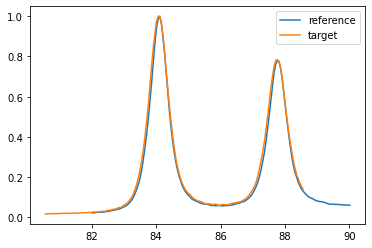

In [21]:
#Testing the phase_cross_correlation() method of registering the curves

reference = gold_scans.iloc[1]['data']
referenceimage = reference[:,1]
target = gold_scans.iloc[20]['data']
targetimage = target[:,1]

correlation = correlate1d(targetimage, referenceimage, mode='nearest')

print(len(correlation))
print("correlation predicted shift: ", int(len(referenceimage)/2-np.argmax(correlation)))
correlation_shift = int(len(referenceimage)/2-np.argmax(correlation))
shift, error, diffphase = phase_cross_correlation(reference, target)
print("phase cross correlation predicted shift:", shift)
print(error)

pixelshift = int(shift[0])
print(type(pixelshift))

# plt.plot(reference[:,1]/np.amax(reference[:,1]))
# plt.plot(target[:,1]/np.amax(target[:,1]))
# plt.plot(correlation/np.amax(correlation))
# plt.legend(['reference','target','correlation'])

plt.plot(reference[:,0],reference[:,1]/np.amax(reference[:,1]))
plt.plot(target[:,0]+-correlation_shift*.05,target[:,1]/np.amax(target[:,1]))
plt.legend(['reference','target'])


Text(0.5, 1.0, 'Au4f')

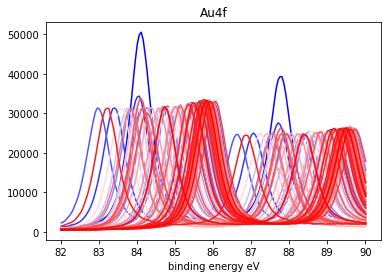

In [22]:
cmap = mpl.cm.bwr
for index, row in gold_scans.iterrows():
    rowdata = row['data']
    plt.plot(rowdata[:,0],rowdata[:,1], c = cmap(index/len(gold_scans)))

plt.xlabel('binding energy eV')
plt.title('Au4f')

Text(0.5, 1.0, 'Au4f aligned using cross correlation')

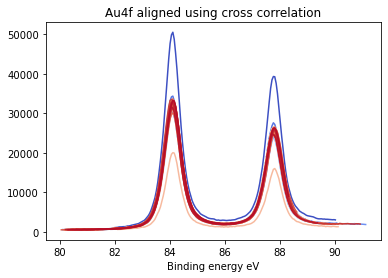

In [23]:
#Run the curve alignment method on the gold data
staticreference = gold_scans.iloc[1]['data'].copy()
aligned_gold = align_spectra(gold_scans, gold_scans.iloc[1]['data'],0.025)
#aligned_gold_moving = moving_window_align_spectra(gold_scans, gold_scans.iloc[1]['data'],0.05,debug=True)
plt.xlabel('Binding energy eV')
plt.title('Au4f aligned using cross correlation')

-2
854.1
0
854.2
0
854.3000000000001
-1
854.1
0
854.3000000000001
3
854.6
2
854.5
3
854.5
4
854.7
-3
853.9000000000001
-1
854.1
-5
853.7
0
854.3000000000001
0
854.3000000000001
1
854.4000000000001
3
854.6
4
854.7
3
854.6
2
854.5
7
853.0
5
852.7
16
853.9000000000001
14
853.8000000000001
12
853.5
-7
851.5
3
852.6
22
854.5
-1
852.1
20
854.3000000000001
20
854.3000000000001
0
852.3000000000001
9
853.3000000000001
23
854.6
14
853.7
11
853.4000000000001
7
853.1
5
852.8000000000001
-5
851.7
22
854.5
-3
851.9000000000001
2
852.5
18
854.2
-5
851.6


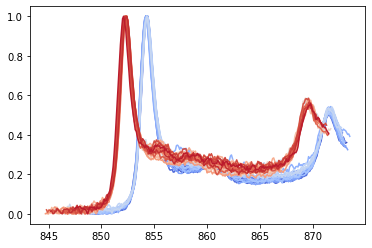

In [24]:
#Run the curve alignment technique method on some experimental heating data
nickel_directory = '/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Live Heating 3-31-23/Ni'
ni_scans = find_snapshots_in_dir(nickel_directory)
ni_reference = ni_scans.iloc[1]['data'].copy()
#plt.plot(ni_reference[:,0],ni_reference[:,1])
aligned_ni = align_spectra(ni_scans,ni_reference,step= 0.05, normalize=True, max_shift = 40,debug=True)
#plt.plot(ni_reference[:,0],ni_reference[:,1],linewidth= 4)


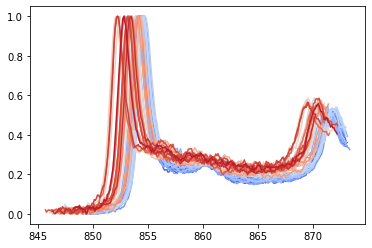

In [25]:
moving_aligned_ni = moving_window_align_spectra(ni_scans, ni_reference, step =.05, normalize = True)
#double_aligned = align_spectra(moving_aligned_ni, ni_reference, step =0.05, normalize = True)
#plot_all_spectra(double_aligned)


(341, 2)


Text(0.5, 1.0, 'Cr 2p3/2 from Ni15Cr stepped heating')

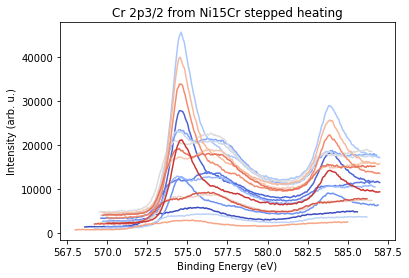

In [30]:
cr_scans = find_snapshots_in_dir("/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Stepped Heating 4-3-23/Cr Mixed")
cr_reference = cr_scans.iloc[1]['data'].copy()
print(cr_reference.shape)
aligned_cr = align_spectra(cr_scans,cr_reference,step=0.05)
plt.xlabel("Binding Energy (eV)")
plt.ylabel("Intensity (arb. u.)")
plt.title("Cr 2p3/2 from Ni15Cr stepped heating")
#moving_aligned_cr = moving_window_align_spectra(cr_scans, cr_reference,normalize=True, step =.1)

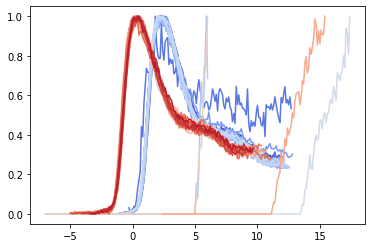

In [27]:
valence_scans = find_snapshots_in_dir("/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Live Heating 3-31-23/Valence")
valence_reference = valence_scans.iloc[1]['data'].copy()
aligned_valence = align_spectra(valence_scans,valence_reference,step=0.05,normalize=True)

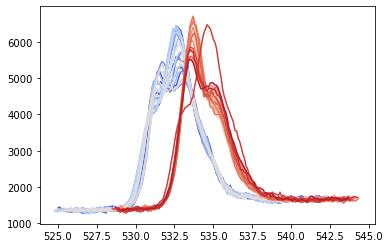

In [28]:
o_scans = find_snapshots_in_dir('/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Live Heating 3-31-23/O')
o_reference = o_scans.iloc[1]['data'].copy()
aligned_o = align_spectra(o_scans,o_reference,step=0.05, max_shift=.01)
#plt.plot(o_reference[:,0],o_reference[:,1],linewidth = 3)

In [29]:

# shifted_data = pd.DataFrame(columns=['data', 'shifted'])
# reference = gold_scans.iloc[1]['data']
# step = reference[0,0]-reference[1,0]

# for index, row in gold_scans.iterrows():
#     target = row['data']
#     shifted = target
#     shift, error, diffphase = phase_cross_correlation(reference, target)
#     print(int(shift[0]))

#     shifted[:,0]+= -step*int(shift[0])
#     shifted_data = shifted_data.append([{'data': row['data'],
#                                 'shifted': shifted
#     }])

#     plt.plot(shifted[:,0],shifted[:,1])